Setting up the Notebook

In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from PIL import Image

from numpy import asarray
import itertools

import os
from google.colab import drive

In [2]:
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/DH/ALZHEIMERS')

Mounted at /content/drive


In [ ]:
ls

Alzheimers.ipynb  train/


Dataset Preparation

In [3]:
im_width = 160
im_height = 160

In [4]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path = os.path.join(img_folder, dir1,  file)
            image = cv.imread(image_path, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (im_height, im_width),interpolation = cv.INTER_AREA)
            image = cv.bitwise_not(image)
            image = np.array(image)
            image = (image * 255).astype(np.uint8)
            img_data_array.append(image)
            class_name.append(dir1)
            
    return img_data_array, class_name

img_array, class_names = create_dataset('train')

In [5]:
print(len(img_array), len(class_names))

200 200


Visualizing the Dataset

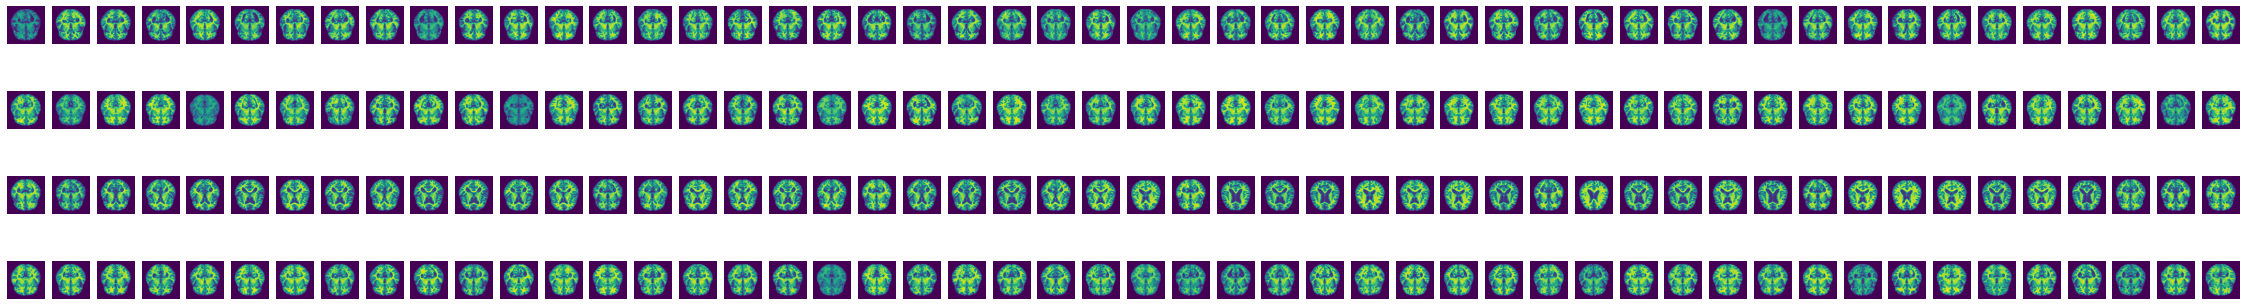

In [ ]:
rows = 4
columns = 50
fig = plt.figure(figsize=(40, 6))

for index, img in enumerate(img_array):
    fig.add_subplot(rows, columns, index+1)
    plt.axis('off')
    plt.imshow(img)

PCA - Principle Component Analysis

In [6]:
def list_convert(img):
  
    # gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = cv.resize(img,(80,120),interpolation = cv.INTER_AREA)
    gray_df = pd.DataFrame(data = gray)
    gray_list = gray_df.values.tolist()    
    gray_list_1D = list(itertools.chain.from_iterable(gray_list))
  
    return(gray_list_1D)

Dataframe of weights and labels

[[-4.66168058e-02  2.15294563e-02  4.76655592e-02 ... -2.90148473e-03
   5.64238254e-04 -9.73954020e-07]
 [-7.04950620e-02  3.20633584e-02  1.35163764e-02 ... -8.24275080e-04
   1.01072534e-02  2.73700769e-03]
 [-7.05669674e-02  2.36224048e-02  6.54378318e-02 ...  1.68402683e-03
   9.82968384e-04  2.09294588e-03]
 ...
 [-5.30714201e-02  2.96295829e-02  6.17058457e-02 ... -7.71361393e-03
  -1.59684472e-03  1.12583665e-03]
 [-6.56214455e-02  4.19831304e-02 -2.91461847e-02 ...  1.18170022e-04
   4.81610286e-03 -3.69475186e-03]
 [-7.65131888e-02  2.72432973e-02  2.26320993e-02 ... -2.41150966e-03
  -7.94492485e-04 -1.41158176e-03]]


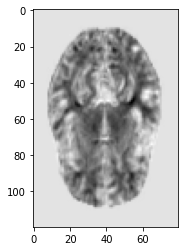

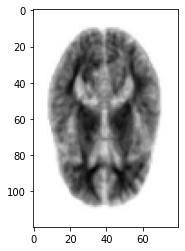

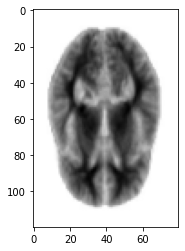

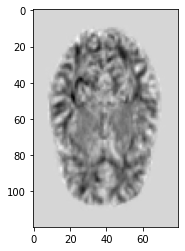

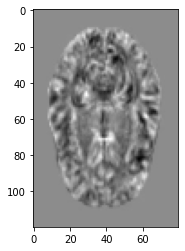

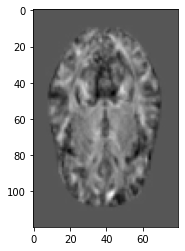

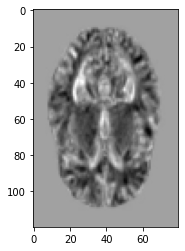

Shape of Eigen Vector:  (7, 9600)


In [7]:
list_images_1D = []

for img in img_array:
   list_images_1D.append(list_convert(img))

list_images_1D = np.asarray(list_images_1D)
avg = np.mean(list_images_1D,axis = 0)

cov_mat = np.matmul(list_images_1D,list_images_1D.T)/200

w , v = np.linalg.eig(cov_mat)
print(v)

eigen_vec = []
for i in range(7):
    eig_temp = np.matmul(v[i],list_images_1D)
    if len(eigen_vec) == 0:
      eigen_vec = eig_temp
    else:
      eigen_vec = np.vstack((eigen_vec,eig_temp))
    eigen_face = np.reshape(eig_temp,(120,80))
    plt.imshow(eigen_face,cmap = 'gray')
    plt.show()

print("Shape of Eigen Vector: ", eigen_vec.shape)

Dataframe of weights and labels

In [8]:
weight_vec_array = []
for img_1D in list_images_1D:
   std_face = np.asarray(img_1D) - np.asarray(avg)
   weight_vec_array.append(np.matmul(eigen_vec,std_face))
weight_vec_array = np.asarray(weight_vec_array)

df_dataset = pd.DataFrame(weight_vec_array,columns = ['w1','w2','w3','w4','w5','w6','w7'])

df_dataset['Label'] = class_names

print(df_dataset)

               w1            w2            w3            w4            w5  \
0    2.382221e+07  6.833803e+07  1.024582e+08  2.055098e+07  3.583397e+06   
1   -1.438808e+05  5.930488e+05  6.817997e+05 -2.871306e+05  1.330614e+05   
2    2.323601e+04  8.164690e+05 -6.893405e+05  1.605700e+06  8.413041e+05   
3    6.191499e+06  1.933787e+07  2.742290e+07  7.093342e+06  2.827015e+06   
4   -5.170414e+06 -1.527975e+07 -2.326666e+07 -4.283143e+06  6.044092e+05   
..            ...           ...           ...           ...           ...   
195 -6.062294e+06 -1.418914e+07 -2.109965e+07 -4.479332e+06  5.731734e+05   
196 -6.965598e+05 -1.267812e+06 -9.263027e+05  7.719509e+05  1.742224e+06   
197  1.797091e+07  5.102510e+07  7.529868e+07  1.626970e+07  3.642377e+06   
198  4.472960e+06  1.548309e+07  2.184310e+07  4.334842e+06  1.556720e+06   
199 -7.217307e+06 -1.726099e+07 -2.543613e+07 -4.870883e+06  6.035760e+05   

               w6            w7             Label  
0   -8.074257e+06  1.40

KNN Classification

In [9]:
x = df_dataset.iloc[:,0:7]
y = df_dataset.iloc[:,7]


x_train, x_test, y_train, y_test = train_test_split( x ,y , random_state=63, test_size = 0.10)

df_test = pd.concat( [pd.DataFrame(x_test),pd.DataFrame(y_test)], axis=1)
df_test.index = [i for i in range(len(x_test))]

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train, y_train)

# Predict on dataset which model has not seen before
pred = knn.predict(x_test)
print('WITH K = 1')
df_test['Predicted'] = pd.DataFrame(pred)

print(df_test[['Predicted','Label']])

# Calculate the accuracy of the model
print("accuracy: ", knn.score(x_test, y_test))


WITH K = 1
           Predicted             Label
0       MildDemented  ModerateDemented
1   VeryMildDemented  VeryMildDemented
2   ModerateDemented  ModerateDemented
3   ModerateDemented  ModerateDemented
4   ModerateDemented  ModerateDemented
5   VeryMildDemented       NonDemented
6   VeryMildDemented  VeryMildDemented
7        NonDemented  VeryMildDemented
8        NonDemented       NonDemented
9   ModerateDemented  ModerateDemented
10       NonDemented       NonDemented
11      MildDemented      MildDemented
12  VeryMildDemented  VeryMildDemented
13  ModerateDemented  ModerateDemented
14  VeryMildDemented  VeryMildDemented
15  VeryMildDemented       NonDemented
16      MildDemented      MildDemented
17       NonDemented       NonDemented
18       NonDemented       NonDemented
19       NonDemented       NonDemented
accuracy:  0.8


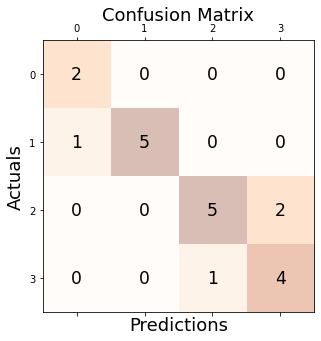

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

conf_matrix = confusion_matrix(y_true=y_test, y_pred=df_test['Predicted'])

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [17]:
print("Accuracy: ", knn.score(x_test, y_test))

Accuracy:  0.8


In [14]:
print('Precision: ', precision_score(y_test, df_test['Predicted'], average='macro'))

Precision:  0.7916666666666666


In [15]:
print('Recall: ', recall_score(y_test, df_test['Predicted'], average='macro'))

Recall:  0.836904761904762


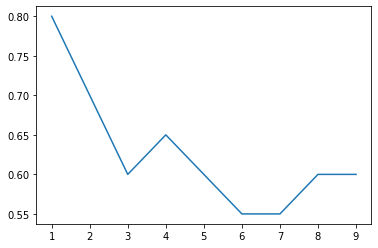

In [ ]:
list1=[]
list2=[i for i in range(1,10)]
for k in range(1,10):
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(x_train, y_train)
  list1.append(knn.score(x_test, y_test))

y=np.array(list1)
k=np.array(list2)
plt.plot(k,y)
plt.show()

